In [1]:
import jwst
import os,re,sys,copy
from jwst.datamodels import ImageModel
from jwst import datamodels
import astropy.units as u
import pysiaf
from pdastro import makepath,rmfile,pdastroclass,pdastrostatsclass,AnotB,AorB,unique,makepath4file
from astropy.io import fits
import numpy as np
from astropy.modeling.models import Polynomial2D, Mapping, Shift
from scipy import linalg
import pandas as pd
import glob
import random
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord

# define colnames of input tables
colnames={}
colnames['x']='x'
colnames['y']='y'
colnames['mag']='mag'
colnames['dmag']='dmag'
colnames['ra']='gaia_ra'
colnames['dec']='gaia_dec'

def v2v3_idl_model(from_sys, to_sys, par, angle):
    """
    Creates an astropy.modeling.Model object
    for the undistorted ("ideal") to V2V3 coordinate translation
    """
    if from_sys != 'v2v3' and to_sys != 'v2v3':
        raise ValueError("This function is designed to generate the transformation either to or from V2V3.")

    # Cast the transform functions as 1st order polynomials
    xc = {}
    yc = {}
    if to_sys == 'v2v3':
        xc['c1_0'] = par * np.cos(angle)
        xc['c0_1'] = np.sin(angle)
        yc['c1_0'] = (0.-par) * np.sin(angle)
        yc['c0_1'] = np.cos(angle)

    if from_sys == 'v2v3':
        xc['c1_0'] = par * np.cos(angle)
        xc['c0_1'] = par * (0. - np.sin(angle))
        yc['c1_0'] = np.sin(angle)
        yc['c0_1'] = np.cos(angle)

    #0,0 coeff should never be used.
    xc['c0_0'] = 0
    yc['c0_0'] = 0

    xmodel = Polynomial2D(1, **xc)
    ymodel = Polynomial2D(1, **yc)

    return xmodel, ymodel

def polyfit0(u, x, y, order):
    """Fit polynomial to a set of u values on an x,y grid.
    u is a function u(x,y) being a polynomial of the form
    u = a[i, j] x**(i-j) y**j. x and y can be on a grid or be arbitrary values
    This version uses scipy.linalg.solve instead of matrix inversion.
    u, x and y must have the same shape and may be 2D grids of values.
    
    **** NOTE: in this routine coeffs[0] is kept at 0! ****
    
    Parameters
    ----------
    u : array
        an array of values to be the results of applying the sought after
        polynomial to the values (x,y)
    x : array
        an array of x values
    y : array
        an array of y values
    order : int
        the polynomial order
    Returns
    -------
    coeffs: array
        polynomial coefficients being the solution to the fit.
    """
    # First set up x and y powers for each coefficient
    px = []
    py = []
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # Important: start the power at 1, not 0!
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    for i in range(1,order + 1):
        for j in range(i + 1):
            px.append(i - j)
            py.append(j)
    terms = len(px)

    # Make up matrix and vector
    vector = np.zeros((terms))
    mat = np.zeros((terms, terms))
    for i in range(terms):
        vector[i] = (u * x ** px[i] * y ** py[i]).sum()  # Summing over all x,y
        for j in range(terms):
            mat[i, j] = (x ** px[i] * y ** py[i] * x ** px[j] * y ** py[j]).sum()

    coeffs = linalg.solve(mat, vector)
    coeffs0 = [0]
    coeffs0.extend(coeffs)
    return coeffs0

def plotit(matches,xcol,ycol,indices=None,ymin=None,ymax=None,xmin=None,xmax=None):
    #sp = plt.subplot(111)
    
    plt.clf()
    plt.rc('font', family='serif')
    plt.figure(figsize=(8,4))
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel(xcol, fontdict=font2)
    plt.ylabel(ycol, fontdict=font2)
    ixs = matches.getindices(indices=indices)
    plt.plot(matches.t.loc[ixs,xcol],matches.t.loc[ixs,ycol],'bo',alpha=0.2)
    #matches.t.loc[ixs].plot(xcol,ycol, **plot_style['data1'])
    if ymin is not None:
        ax = plt.gca()
        ax.set_ylim([ymin, ymax])
    if xmin is not None:
        ax = plt.gca()
        ax.set_xlim([xmin, xmax])
    plt.show()

def initplot(nrows=1, ncols=1, xfigsize4subplot=5, yfigsize4subplot=None, **kwargs):
    sp=[]
    if yfigsize4subplot is None: yfigsize4subplot=xfigsize4subplot
    xfigsize=xfigsize4subplot*ncols
    yfigsize=yfigsize4subplot*nrows
    plt.figure(figsize=(xfigsize,yfigsize))
    counter=1
    for row in range(nrows):
        for col in range(ncols):
            sp.append(plt.subplot(nrows, ncols, counter,**kwargs))
            counter+=1

    for i in range(len(sp)):
        plt.setp(sp[i].get_xticklabels(),'fontsize',12)
        plt.setp(sp[i].get_yticklabels(),'fontsize',12)
        sp[i].set_xlabel(sp[i].get_xlabel(),fontsize=14)
        sp[i].set_ylabel(sp[i].get_ylabel(),fontsize=14)
        sp[i].set_title(sp[i].get_title(),fontsize=14)

    return(sp)


**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-059 CANNOT BE CHECKED AGAINST ONLINE VERSION


In [48]:
filtername = 'F335M'
pupilname = 'MASKRND'
verbose=1
# correct v2/v3 
correctV2V3Flag=True
# this can be 'header', 'siafaperture', or 'center'. defines from where the target V2/V3ref 
# and V3idlYAng values are taken from
V2V3ref_method = 'center' 

inputrootdir = '/Users/arest/nircam/jwst_coron_distortions/jhat/v1/f335m_maskrnd'
fullimagenames = glob.glob(f'{inputrootdir}/jw01481*_nrcalong_jhat.fits')
print(f'{len(fullimagenames)} images found')

# These directories are later combined for the output basename
outrootdir = '/Users/arest/nircam/jwst_alignment_tools/coron/distortions'
outsubdir = 'test_v1'


6 images found


In [49]:
# this is preparing the images and getting the information like siaf aperture

# only keep images with correct filter and puppil
fullimagenames_filter=[]
apernamelist = []
instrumentlist =[]
v2refs_hdr=[]
v3refs_hdr=[]
v3yangs_hdr=[]
for fullimagename in fullimagenames:
    hdr0 = fits.getheader(fullimagename)
    hdr1 = fits.getheader(fullimagename,ext=1)
    print(f'{hdr0["FILTER"].upper()} {hdr0["PUPIL"].upper()}')
    #image_model = ImageModel(fullimagename)
    #if image_model.meta.instrument.filter.upper()!=filtername:
    if hdr0["FILTER"].upper()!=filtername:
        if verbose>1: print (f'filter={hdr0["FILTER"].upper()}!={filtername}: Skipping {fullimagename} ')
        continue
    if hdr0["PUPIL"].upper()!=pupilname:
        if verbose>1: print (f'filter={hdr0["PUPIL"].upper()}!={pupilname}: Skipping {fullimagename} ')
        continue
    print (f'Keeping {fullimagename} {hdr0["FILTER"]} {hdr0["PUPIL"]}')
    fullimagenames_filter.append(fullimagename)
    apernamelist.append(hdr0['APERNAME'])
    instrumentlist.append(hdr0['INSTRUME'])
    v2refs_hdr.append(hdr1["V2_REF"])
    v3refs_hdr.append(hdr1["V3_REF"])
    v3yangs_hdr.append(hdr1["V3I_YANG"])

# just use 2 images for debugging
# fullimagenames_filter=fullimagenames_filter[:1]

print(f'{len(fullimagenames_filter)} images found with correct filter={filtername} and pupil={pupilname}')
if len(fullimagenames_filter)<1:
    raise RuntimeError('No images!!')

apernamelist = unique(apernamelist)
instrumentlist = unique(instrumentlist)
if len(apernamelist)!=1: raise RuntimeError(f'more than 1 apertures!! {apernamelist}')
if len(instrumentlist)!=1: raise RuntimeError(f'more than 1 apertures!! {instrumentlist}')

if verbose: print(f'initializing siaf aperture for {instrumentlist[0]} {apernamelist[0]}')
siaf_instrument = pysiaf.Siaf(instrumentlist[0]) 
siaf_aperture = siaf_instrument.apertures[apernamelist[0]]

if V2V3ref_method.lower() == 'header':
    if len(v2refs_hdr)!=1: raise RuntimeError(f'V2_REF list from header does not exactly have one entry: {v2refs_hdr}')
    if len(v3refs_hdr)!=1: raise RuntimeError(f'V3_REF list from header does not exactly have one entry: {v3refs_hdr}')
    if len(v3yangs_hdr)!=1: raise RuntimeError(f'V3I_YANG list from header does not exactly have one entry: {v3yangs_hdr}')
    target_v2ref = float(v2refs_hdr[0])
    target_v3ref = float(v3refs_hdr[0])
    target_V3IdlYAngle = float(v3yangs_hdr[0])
elif V2V3ref_method.lower() == 'siafaperture':
    target_v2ref = siaf_aperture.V2Ref
    target_v3ref = siaf_aperture.V3Ref
    target_V3IdlYAngle = siaf_aperture.V3IdlYAngle
elif V2V3ref_method.lower() == 'center':
    # nothing to do yet!
    target_v2ref = None
    target_v3ref = None
    target_V3IdlYAngle = None
else:
    raise RuntimeError(f'{V2V3ref_method} not allowed for V2V3ref_method, only header, siafaperture, center allowed')

print(f'V2V3ref_method={V2V3ref_method}: target (V2ref,V3ref,V3IdlYAngle)=({target_v2ref},{target_v3ref},{target_V3IdlYAngle})')

outbasename = f'{outrootdir}/{outsubdir}/{apernamelist[0]}_{filtername}_{pupilname}'
print(f'\n###\nOutput basename: {outbasename}\n###')
### make sure the path exists
makepath4file(outbasename)

F335M MASKRND
Keeping /Users/arest/nircam/jwst_coron_distortions/jhat/v1/f335m_maskrnd/jw01481002001_04101_00001_nrcalong_jhat.fits F335M MASKRND
F335M MASKRND
Keeping /Users/arest/nircam/jwst_coron_distortions/jhat/v1/f335m_maskrnd/jw01481002001_04101_00002_nrcalong_jhat.fits F335M MASKRND
F335M MASKRND
Keeping /Users/arest/nircam/jwst_coron_distortions/jhat/v1/f335m_maskrnd/jw01481001002_04101_00002_nrcalong_jhat.fits F335M MASKRND
F335M MASKRND
Keeping /Users/arest/nircam/jwst_coron_distortions/jhat/v1/f335m_maskrnd/jw01481001002_04101_00001_nrcalong_jhat.fits F335M MASKRND
F335M MASKRND
Keeping /Users/arest/nircam/jwst_coron_distortions/jhat/v1/f335m_maskrnd/jw01481002002_04101_00001_nrcalong_jhat.fits F335M MASKRND
F335M MASKRND
Keeping /Users/arest/nircam/jwst_coron_distortions/jhat/v1/f335m_maskrnd/jw01481002002_04101_00002_nrcalong_jhat.fits F335M MASKRND
6 images found with correct filter=F335M and pupil=MASKRND
initializing siaf aperture for NIRCAM NRCA5_FULL
V2V3ref_method=c

0

In [4]:
# check if this is an image for which a coronographic mask causes a step in the y direction in the COM region!
maskinfoname = './MaskInfo.txt'
# This file has the format:
# aperture filter   pupil  y_transition  y_step_pixels  y_cut_min  y_cut_max  y_cut_top_edge
# all entries are in lower case
maskinfo = pdastroclass()

maskinfo.load(maskinfoname)
print('mask info file:')
maskinfo.write()
# uncomment this if you want to save the maskinfo file and have the columns reformatted. 
# this is useful if you have added entries to the maskinfo file
# maskinfo.write(maskinfoname)

# check if their is an entry in the maskinfo file for this aperture/filter/pupil!
ixs_mask = maskinfo.ix_equal('aperture',apernamelist[0].lower())
ixs_mask = maskinfo.ix_equal('filter',filtername.lower(),indices=ixs_mask)
ixs_mask = maskinfo.ix_equal('pupil',pupilname.lower(),indices=ixs_mask)
if len(ixs_mask)==0:
    print('\n**** This is a normal image without a coronographic mask causing a step!! ***')
    COMflag=False
    y_transition=y_step_pixels=y_cut_min=y_cut_max=y_cut_top_edge=None
elif len(ixs_mask)==1:
    ix = ixs_mask[0]
    print('\n****\n**** This is an image with a coronographic mask causing a step!! ***\n****')
    print('step info for this image:')
    maskinfo.write(indices=[ix])
    y_transition = maskinfo.t.loc[ix,'y_transition']
    y_step_pixels = maskinfo.t.loc[ix,'y_step_pixels']
    y_cut_min = maskinfo.t.loc[ix,'y_cut_min']
    y_cut_max = maskinfo.t.loc[ix,'y_cut_max']  
    y_cut_top_edge = maskinfo.t.loc[ix,'y_cut_top_edge']
    COMflag=True
else:
    raise RuntimeError(f'more than one entry {ixs_mask}')


mask info file:
  aperture filter   pupil  y_transition  y_step_pixels  y_cut_min  y_cut_max  y_cut_top_edge
nrca5_full  f335m maskrnd          1490           0.45       1450       1550            1750

****
**** This is an image with a coronographic mask causing a step!! ***
****
step info for this image:
  aperture filter   pupil  y_transition  y_step_pixels  y_cut_min  y_cut_max  y_cut_top_edge
nrca5_full  f335m maskrnd          1490           0.45       1450       1550            1750


In [50]:
# Load the tables, calculate refcat v2/v3 from refcat ra,dec, and populate detector info columns
frames = {}
imtable=pdastroclass()
for counter,fullimagename in enumerate(fullimagenames_filter):
    imagename = os.path.basename(fullimagename)
    goodtablefilename = re.sub('\.fits$','.good.phot.txt',fullimagename)
    # Load the table into hash
    frames[counter] = pd.read_csv(goodtablefilename,sep='\s+')
    if len(frames[counter])<1:
        raise RuntimeError(f'file {goodtablefilename} has no data!')

    # only keep relevant columns
    frames[counter] = frames[counter][list(colnames.values())].copy()
    
    # save the filename and assign ID
    frames[counter]['imagename']=imagename
    frames[counter]['imID']=counter
    
    # Get detector info and save in table
    image_model = ImageModel(fullimagename)
    #print(image_model.meta.instance) 
    #print(image_model.meta.instrument.filter)
    #print(image_model.meta.instrument.instance)

    frames[counter]['instrument']=image_model.meta.instrument.name
    frames[counter]['detector']=image_model.meta.instrument.detector
    frames[counter]['aperture']=image_model.meta.aperture.name
    frames[counter]['filter']=image_model.meta.instrument.filter
    frames[counter]['pupil']=image_model.meta.instrument.pupil
    
    ix_im = imtable.newrow({
        'imID':counter,
        'image':imagename,
        'fullimage':fullimagename,
        'aperture':image_model.meta.aperture.name,
        'filter':image_model.meta.instrument.filter,
        'pupil':image_model.meta.instrument.pupil
    })
    
    # Calculate v2/v3 from refcat ra/dec
    # This should be independent of the distortions, it just depends if the WCS alignment is good
    # enough with default distortions
    world_to_v2v3 = image_model.meta.wcs.get_transform('world', 'v2v3')
    (frames[counter]['refcat_v2'], frames[counter]['refcat_v3']) = world_to_v2v3(frames[counter][colnames['ra']],frames[counter][colnames['dec']])

    # original xy to radec, including default distortions
    detector_to_world = image_model.meta.wcs.get_transform('detector', 'world')
    (frames[counter]['ra_old'], frames[counter]['dec_old']) = detector_to_world(frames[counter][colnames['x']],frames[counter][colnames['y']])

    # original radec to xy, including default distortions
    world_to_detector = image_model.meta.wcs.get_transform('world', 'detector')
    (frames[counter]['refcat_x'], frames[counter]['refcat_y']) = world_to_detector(frames[counter][colnames['ra']],frames[counter][colnames['dec']])

    #siaf_instrument = pysiaf.Siaf(image_model.meta.instrument.name) 
    #siaf_aperture = siaf_instrument.apertures[image_model.meta.aperture.name]

    # just a check
    scihdr = fits.getheader(fullimagename,extname='SCI')
    print(f'V2V3 header: ({scihdr["V2_REF"]:.6f},{scihdr["V3_REF"]:.6f})')

    detector_to_v2v3 = image_model.meta.wcs.get_transform('detector', 'v2v3')
    v2center,v3center = detector_to_v2v3(siaf_aperture.XSciRef-1.0,siaf_aperture.YSciRef-1.0)
    
    v2_1,v3_1 = detector_to_v2v3(siaf_aperture.XSciRef-1.0,siaf_aperture.YSciRef-1.0+0.5)
    v2_2,v3_2 = detector_to_v2v3(siaf_aperture.XSciRef-1.0,siaf_aperture.YSciRef-1.0-0.5)
    pos1 = SkyCoord(ra=v2_1, dec=v3_1, unit=(u.arcsec,u.arcsec), frame='icrs')
    pos2 = SkyCoord(ra=v2_2, dec=v3_2, unit=(u.arcsec,u.arcsec), frame='icrs')
    V3IdlYAngle_center = pos1.position_angle(pos2).to(u.deg)
    if V3IdlYAngle_center.degree>90: 
        V3IdlYAngle_center-=180.0*u.deg
    if V3IdlYAngle_center.degree<-90:
        V3IdlYAngle_center+=180.0*u.deg

    if V2V3ref_method.lower() == 'center':
        target_v2ref = float(v2center)
        target_v3ref = float(v3center)
        target_V3IdlYAngle = float(V3IdlYAngle_center.degree)
    
    dv2 = target_v2ref - v2center
    dv3 = target_v3ref - v3center
    print(f'V2V3 comparison: ({target_v2ref:.6f},{target_v3ref:.6f}) ({v2center},{v3center})')
    print(f'Difference dV2={dv2:.6f} dV3={dv3:.6f}')

    frames[counter]['v2ref'] = target_v2ref
    frames[counter]['v3ref'] = target_v3ref

    imtable.t.loc[ix_im,['targetV2ref','targetV3ref','targetV3IdlYAngle','V2center','V3center','V3IdlYAnglecenter','dV2','dV3']]=[target_v2ref,target_v3ref,target_V3IdlYAngle,v2center,v3center,V3IdlYAngle_center.degree,dv2,dv3]
    
    #v2v3_to_world = image_model.meta.wcs.get_transform('v2v3','world')
    #(ra0,dec0)=v2v3_to_world(siaf_aperture.V2Ref,siaf_aperture.V3Ref) 
    #print('vvvvvv',world_to_detector(ra0,dec0))
    
    print(f'Loaded {len(frames[counter])} rows for imID={counter}')
    
# Merge the tables into one mastertable
print(f'Loaded {counter+1} tables')
matches = pdastrostatsclass()
matches.t = pd.concat(frames,ignore_index=True)
print(f'{len(matches.t)} rows total')
imtable.write()


V2V3 header: (85.939298,-493.510653)
V2V3 comparison: (83.876804,-446.063595) (83.876804,-446.063595)
Difference dV2=0.000000 dV3=0.000000
Loaded 613 rows for imID=0
V2V3 header: (85.939298,-493.510653)
V2V3 comparison: (83.876804,-446.063595) (83.876804,-446.063595)
Difference dV2=0.000000 dV3=0.000000
Loaded 610 rows for imID=1
V2V3 header: (85.939298,-493.510653)
V2V3 comparison: (83.876804,-446.063595) (83.876804,-446.063595)
Difference dV2=0.000000 dV3=0.000000
Loaded 622 rows for imID=2
V2V3 header: (85.939298,-493.510653)
V2V3 comparison: (83.876804,-446.063595) (83.876804,-446.063595)
Difference dV2=0.000000 dV3=0.000000
Loaded 617 rows for imID=3
V2V3 header: (85.939298,-493.510653)
V2V3 comparison: (83.876804,-446.063595) (83.876804,-446.063595)
Difference dV2=0.000000 dV3=0.000000
Loaded 657 rows for imID=4
V2V3 header: (85.939298,-493.510653)
V2V3 comparison: (83.876804,-446.063595) (83.876804,-446.063595)
Difference dV2=0.000000 dV3=0.000000
Loaded 667 rows for imID=5
Load

0

In [51]:

parity = siaf_aperture.VIdlParity
v3_ideal_y_angle = siaf_aperture.V3IdlYAngle * np.pi / 180.

refcat_v2_col4fit = 'refcat_v2'
refcat_v3_col4fit = 'refcat_v3'

for ix_imtable in imtable.getindices():
    imID=imtable.t.loc[ix_imtable,'imID']
    # correct for the v2v3 shift!
    ixs_imID =matches.ix_equal('imID',imID)
    #print(f'{imID}: V3IdlYAnglecenter={imtable.t.loc[ix_imtable,"V3IdlYAnglecenter"]}')
    v2v32idlx, v2v32idly = v2v3_idl_model('v2v3', 'ideal', parity, imtable.t.loc[ix_imtable,'V3IdlYAnglecenter']* np.pi / 180.)

    matches.t.loc[ixs_imID,'refcat_x_idl'] = v2v32idlx(matches.t.loc[ixs_imID,refcat_v2_col4fit]-matches.t.loc[ixs_imID,'v2ref'],
                                                       matches.t.loc[ixs_imID,refcat_v3_col4fit]-matches.t.loc[ixs_imID,'v3ref'])
    matches.t.loc[ixs_imID,'refcat_y_idl'] = v2v32idly(matches.t.loc[ixs_imID,refcat_v2_col4fit]-matches.t.loc[ixs_imID,'v2ref'],
                                                       matches.t.loc[ixs_imID,refcat_v3_col4fit]-matches.t.loc[ixs_imID,'v3ref'])

matches.t['xprime'] =  matches.t['x'] + 1 - siaf_aperture.XSciRef 
matches.t['yprime'] =  matches.t['y'] + 1 - siaf_aperture.YSciRef 

debug = False
# these are by default read in by the maskinfo file, only set debug=True for debugging!!
if debug:
    y_transition = 1490
    y_step_pixels = 0.45
    # this defines the region that gets completely cut and not used for the fit
    y_cut_min = 1450
    y_cut_max = 1550
    # cut also above y>y_cut_top_edge
    y_cut_top_edge = 1750
    COMflag = True

    
if COMflag:

    #ixs_bottom = matches.ix_inrange('y',None,y_transition)
    #ixs_top = AnotB(matches.getindices(),ixs_bottom)
    ixs_top = matches.ix_inrange('y',y_transition,None)
    matches.t.loc[ixs_top,'yprime'] +=  y_step_pixels

    ixs_transition = matches.ix_inrange('y',y_cut_min,y_cut_max)
    ixs_use = AnotB(matches.getindices(),ixs_transition)
    if (y_cut_top_edge is not None) and (y_cut_top_edge!=np.nan):
        ixs_use = matches.ix_inrange('y',None,y_cut_top_edge,indices=ixs_use)
        
    
    #ixs_use = matches.ix_inrange('y',y_cut_max,y_cut_top_edge)
    #ixs_use = AorB(ixs_use,matches.ix_inrange('y',None,y_cut_min))
    #ixs_bottom4fit = matches.ix_inrange('y',None,y_cut_min)
    # Only keep Nkeep from the bottom to make sure that the top gets favored!
    #Nkeep = int(len(ixs_use)*0.2)
    #ixs_use = AorB(ixs_use,random.choices(ixs_bottom4fit,k=Nkeep))
else:
    ixs_use = matches.getindices()
    
#ixs_use = AorB(ixs_use,ixs_bottom4fit)
#ixs_use0 = copy.deepcopy(ixs_use)

# the excluded indices are saved here
ixs_excluded =  AnotB(matches.getindices(),ixs_use)
print(f'{len(ixs_use)} entries used for fit, {len(ixs_excluded)} excluded')

3465 entries used for fit, 321 excluded


In [47]:
converged = False
counter = 0

# start fresh!
ixs4fit=copy.deepcopy(ixs_use)
poly_degree = 5


while not converged:
    coeff_Sci2IdlX = polyfit0(matches.t.loc[ixs4fit,'refcat_x_idl'], matches.t.loc[ixs4fit,'xprime'], matches.t.loc[ixs4fit,'yprime'],order=poly_degree)
    coeff_Sci2IdlY = polyfit0(matches.t.loc[ixs4fit,'refcat_y_idl'], matches.t.loc[ixs4fit,'xprime'], matches.t.loc[ixs4fit,'yprime'],order=poly_degree)

    matches.t['x_idl_fit'] = pysiaf.utils.polynomial.poly(coeff_Sci2IdlX, matches.t['xprime'], matches.t['yprime'], order=poly_degree)
    matches.t['y_idl_fit'] = pysiaf.utils.polynomial.poly(coeff_Sci2IdlY, matches.t['xprime'], matches.t['yprime'], order=poly_degree)
    matches.t['dx_idl_pix']  = (matches.t['refcat_x_idl'] - matches.t['x_idl_fit']) / coeff_Sci2IdlX[1]
    matches.t['dy_idl_pix']  = (matches.t['refcat_y_idl'] - matches.t['y_idl_fit']) / coeff_Sci2IdlY[2]

    matches.calcaverage_sigmacutloop('dx_idl_pix',indices=ixs4fit,verbose=0,Nsigma=3,percentile_cut_firstiteration=80)
    #print(matches.statparams)
    Nclip = matches.statparams['Nclip']
    ixs4fit = matches.statparams['ix_good']

    matches.calcaverage_sigmacutloop('dy_idl_pix',indices=ixs4fit,verbose=0,Nsigma=3,percentile_cut_firstiteration=80)
    #print(matches.statparams)
    # add the Nclip from y to the Nclip from x
    Nclip += matches.statparams['Nclip']
    ixs4fit = matches.statparams['ix_good']

    counter+=1
    if Nclip<1:
        print('CONVERGED!!!!!!')
        converged = True
    else:
        print(f'iteraton {counter}: {Nclip} clipped, {len(ixs4fit)} kept')
        
    if counter>20:
        converged = True
ixs_cut_3sigma = AnotB(ixs_use,ixs4fit)    
print(f'3-sigma clip result: {len(ixs_cut_3sigma)} ({len(ixs_cut_3sigma)/len(ixs_use)*100.0:.1f}%) out of {len(ixs_use)} clipped')
matches.t['cutflag']=8   ### All 8 should be overwritten by the following commands! If not it's a bug!!
matches.t.loc[ixs4fit,'cutflag']=0
matches.t.loc[ixs_cut_3sigma,'cutflag']=1
matches.t.loc[ixs_excluded,'cutflag']=2

outfilename = f'{outbasename}.matches.txt'
print(f'Saving {outfilename}')
matches.write(outfilename)

outfilename = f'{outbasename}.images.txt'
print(f'Saving {outfilename}')
imtable.write(outfilename)


2023-11-21 19:14:48,718 - stpipe - WARNING - /var/folders/16/91kljsb17fd5xnw3fr_fdj70000149/T/ipykernel_5534/2094351431.py:105: LinAlgWarning: Ill-conditioned matrix (rcond=9.16736e-26): result may not be accurate.
  coeffs = linalg.solve(mat, vector)

2023-11-21 19:14:48,858 - stpipe - WARNING - /var/folders/16/91kljsb17fd5xnw3fr_fdj70000149/T/ipykernel_5534/2094351431.py:105: LinAlgWarning: Ill-conditioned matrix (rcond=9.16736e-26): result may not be accurate.
  coeffs = linalg.solve(mat, vector)

2023-11-21 19:14:49,028 - stpipe - WARNING - /var/folders/16/91kljsb17fd5xnw3fr_fdj70000149/T/ipykernel_5534/2094351431.py:105: LinAlgWarning: Ill-conditioned matrix (rcond=9.2573e-26): result may not be accurate.
  coeffs = linalg.solve(mat, vector)



iteraton 1: 159 clipped, 3306 kept


2023-11-21 19:14:49,168 - stpipe - WARNING - /var/folders/16/91kljsb17fd5xnw3fr_fdj70000149/T/ipykernel_5534/2094351431.py:105: LinAlgWarning: Ill-conditioned matrix (rcond=9.2573e-26): result may not be accurate.
  coeffs = linalg.solve(mat, vector)

2023-11-21 19:14:49,344 - stpipe - WARNING - /var/folders/16/91kljsb17fd5xnw3fr_fdj70000149/T/ipykernel_5534/2094351431.py:105: LinAlgWarning: Ill-conditioned matrix (rcond=9.27346e-26): result may not be accurate.
  coeffs = linalg.solve(mat, vector)



iteraton 2: 9 clipped, 3297 kept


2023-11-21 19:14:49,486 - stpipe - WARNING - /var/folders/16/91kljsb17fd5xnw3fr_fdj70000149/T/ipykernel_5534/2094351431.py:105: LinAlgWarning: Ill-conditioned matrix (rcond=9.27346e-26): result may not be accurate.
  coeffs = linalg.solve(mat, vector)

2023-11-21 19:14:49,661 - stpipe - WARNING - /var/folders/16/91kljsb17fd5xnw3fr_fdj70000149/T/ipykernel_5534/2094351431.py:105: LinAlgWarning: Ill-conditioned matrix (rcond=9.27398e-26): result may not be accurate.
  coeffs = linalg.solve(mat, vector)



iteraton 3: 1 clipped, 3296 kept


2023-11-21 19:14:49,803 - stpipe - WARNING - /var/folders/16/91kljsb17fd5xnw3fr_fdj70000149/T/ipykernel_5534/2094351431.py:105: LinAlgWarning: Ill-conditioned matrix (rcond=9.27398e-26): result may not be accurate.
  coeffs = linalg.solve(mat, vector)



CONVERGED!!!!!!
3-sigma clip result: 169 (4.9%) out of 3465 clipped
Saving /Users/arest/nircam/jwst_alignment_tools/coron/distortions/test_v1/NRCA5_FULL_F335M_MASKRND.matches.txt
Saving /Users/arest/nircam/jwst_alignment_tools/coron/distortions/test_v1/NRCA5_FULL_F335M_MASKRND.images.txt


0

[<AxesSubplot: title={'center': 'NRCA5_FULL F335M MASKRND'}, xlabel='y', ylabel='dy_idl_pix'>,
 <AxesSubplot: xlabel='x', ylabel='dx_idl_pix'>,
 <AxesSubplot: xlabel='y', ylabel='dy_idl_pix'>]

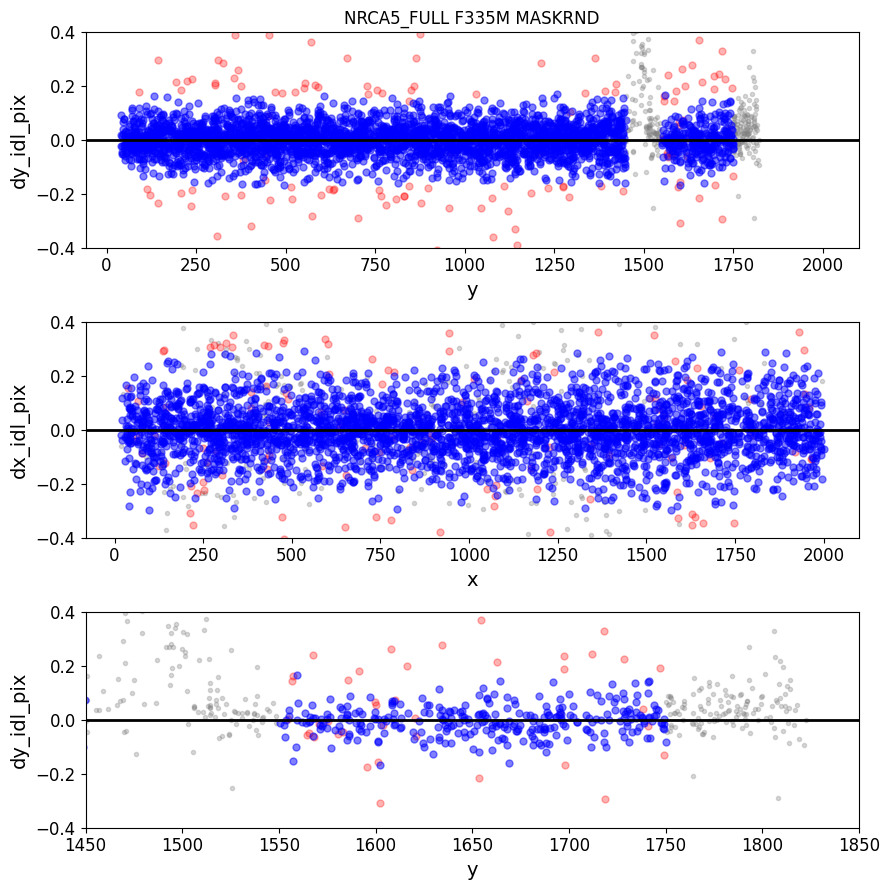

In [32]:
plot_style={}
plot_style['good']={'style':'o','color':'blue', 'ms':5 ,'alpha':0.5}
plot_style['cut']={'style':'o','color':'red', 'ms':5 ,'alpha':0.3}
plot_style['excluded']={'style':'o','color':'gray', 'ms':3 ,'alpha':0.3}

def plot_residuals(table, ixs_good, ixs_cut, ixs_excluded, sp=None, residual_limits=(-0.4,0.4), COM_yrange = (1450,1850),
                  xfigsize4subplot=9, yfigsize4subplot=3,
                  add2title=None,
                  COMflag=True,shortflag=True):
    if sp is None:
        if shortflag:
            sp=initplot(3,1, xfigsize4subplot=xfigsize4subplot, yfigsize4subplot=yfigsize4subplot)
        else:    
            if COMflag:
                sp=initplot(8,1, xfigsize4subplot=xfigsize4subplot, yfigsize4subplot=yfigsize4subplot)
            else:
                sp=initplot(6,1, xfigsize4subplot=xfigsize4subplot, yfigsize4subplot=yfigsize4subplot)

    title = f'{apernamelist[0]} {filtername} {pupilname}'
    if add2title is not None: title+=f' {add2title}'
    ### dy vs y
    if len(ixs_excluded)>0: table.t.loc[ixs_excluded].plot('y','dy_idl_pix',ax=sp[0],ylim=residual_limits,ylabel='dy_idl_pix', **plot_style['excluded'])
    if len(ixs_cut)>0: table.t.loc[ixs_cut].plot('y','dy_idl_pix',ax=sp[0],ylim=residual_limits,ylabel='dy_idl_pix', **plot_style['cut'])
    table.t.loc[ixs_good].plot('y','dy_idl_pix',ax=sp[0],ylim=residual_limits,ylabel='dy_idl_pix',title=title, **plot_style['good'])

    ### dx vs x
    if len(ixs_excluded)>0: table.t.loc[ixs_excluded].plot('x','dx_idl_pix',ax=sp[1],ylim=residual_limits,ylabel='dx_idl_pix', **plot_style['excluded'])
    if len(ixs_cut)>0: table.t.loc[ixs_cut].plot('x','dx_idl_pix',ax=sp[1],ylim=residual_limits,ylabel='dx_idl_pix', **plot_style['cut'])
    table.t.loc[ixs_good].plot('x','dx_idl_pix',ax=sp[1],ylim=residual_limits,ylabel='dx_idl_pix', **plot_style['good'])

    if not shortflag:
        ### dy vs x
        if len(ixs_excluded)>0: table.t.loc[ixs_excluded].plot('x','dy_idl_pix',ax=sp[2],ylim=residual_limits,ylabel='dy_idl_pix', **plot_style['excluded'])
        if len(ixs_cut)>0: table.t.loc[ixs_cut].plot('x','dy_idl_pix',ax=sp[2],ylim=residual_limits,ylabel='dy_idl_pix', **plot_style['cut'])
        table.t.loc[ixs_good].plot('x','dy_idl_pix',ax=sp[2],ylim=residual_limits,ylabel='dy_idl_pix', **plot_style['good'])

    
        ### dx vs y
        if len(ixs_excluded)>0: table.t.loc[ixs_excluded].plot('x','dx_idl_pix',ax=sp[3],ylim=residual_limits,ylabel='dy_idl_pix', **plot_style['excluded'])
        if len(ixs_cut)>0: table.t.loc[ixs_cut].plot('x','dx_idl_pix',ax=sp[3],ylim=residual_limits,ylabel='dy_idl_pix', **plot_style['cut'])
        table.t.loc[ixs_good].plot('x','dx_idl_pix',ax=sp[3],ylim=residual_limits,ylabel='dx_idl_pix', **plot_style['good'])

        for i in range(4): 
            sp[i].axhline(0,  color='black',linestyle='-', linewidth=2.0)

        if COMflag:
            ### dy vs y, COM
            if len(ixs_excluded)>0: table.t.loc[ixs_excluded].plot('y','dy_idl_pix',ax=sp[4],ylim=residual_limits,xlim=COM_yrange,ylabel='dy_idl_pix', **plot_style['excluded'])
            if len(ixs_cut)>0: table.t.loc[ixs_cut].plot('y','dy_idl_pix',ax=sp[4],ylim=residual_limits,xlim=COM_yrange,ylabel='dy_idl_pix', **plot_style['cut'])
            table.t.loc[ixs_good].plot('y','dy_idl_pix',ax=sp[4],ylim=residual_limits,xlim=COM_yrange,ylabel='dy_idl_pix', **plot_style['good'])

            ### dx vs x, COM
            if len(ixs_excluded)>0: table.t.loc[ixs_excluded].plot('y','dx_idl_pix',ax=sp[5],ylim=residual_limits,xlim=COM_yrange,ylabel='dy_idl_pix', **plot_style['excluded'])
            if len(ixs_cut)>0: table.t.loc[ixs_cut].plot('y','dx_idl_pix',ax=sp[5],ylim=residual_limits,xlim=COM_yrange,ylabel='dy_idl_pix', **plot_style['cut'])
            table.t.loc[ixs_good].plot('y','dx_idl_pix',ax=sp[5],ylim=residual_limits,xlim=COM_yrange,ylabel='dx_idl_pix', **plot_style['good'])

            for i in range(4,6): 
                sp[i].axhline(0,  color='black',linestyle='-', linewidth=2.0)

            ### V3 residuals with respect to y in pixel coordinates
            ypixscale = coeff_Sci2IdlY[2]
            table.t['v3res_pix'] = table.t[refcat_v3_col4fit]/ypixscale - table.t['y'] 
            ixs_centercols = table.ix_inrange('x',900,1100,indices=ixs_good)
            table.t.loc[ixs_centercols].plot('y','v3res_pix',ax=sp[6],ylabel='v3res [pixel]', **plot_style['good'])
            table.t.drop(columns=['v3res_pix'],inplace=True)

            ### V2 residuals with respect to x in pixel coordinates
            xpixscale = coeff_Sci2IdlX[1]
            table.t['v2res_pix'] = table.t[refcat_v2_col4fit]/xpixscale + table.t['x'] 
            ixs_COMrows = table.ix_inrange('y',1550,1700,indices=ixs_good)
            table.t.loc[ixs_COMrows].plot('x','v2res_pix',ax=sp[7],ylabel='v2res [pixel]', **plot_style['good'])
            table.t.drop(columns=['v2res_pix'],inplace=True)

    else:
        ### dy vs y, COM
        if len(ixs_excluded)>0: table.t.loc[ixs_excluded].plot('y','dy_idl_pix',ax=sp[2],ylim=residual_limits,xlim=COM_yrange,ylabel='dy_idl_pix', **plot_style['excluded'])
        if len(ixs_cut)>0: table.t.loc[ixs_cut].plot('y','dy_idl_pix',ax=sp[2],ylim=residual_limits,xlim=COM_yrange,ylabel='dy_idl_pix', **plot_style['cut'])
        table.t.loc[ixs_good].plot('y','dy_idl_pix',ax=sp[2],ylim=residual_limits,xlim=COM_yrange,ylabel='dy_idl_pix', **plot_style['good'])
        for i in range(3): 
            sp[i].axhline(0,  color='black',linestyle='-', linewidth=2.0)
            

    #for i in range(3): sp[i].get_legend().remove()
    for i in range(len(sp)): 
        if sp[i].get_legend() is not None:
            sp[i].get_legend().remove()

    plt.tight_layout()
    return(sp)

## plot a short version of the residuals, using shortflag=True
plot_residuals(matches, ixs4fit, ixs_cut_3sigma, ixs_excluded,
               residual_limits = (-0.4,0.4),COM_yrange = (1450,1850),COMflag=COMflag,shortflag=True)

#matches.write()


[-1, 0, 1, 2, 3, 4, 5]
Saving /Users/arest/nircam/jwst_alignment_tools/coron/distortions/test_v1/NRCA5_FULL_F335M_MASKRND.all.residuals.png
Saving /Users/arest/nircam/jwst_alignment_tools/coron/distortions/test_v1/NRCA5_FULL_F335M_MASKRND.imID_0.residuals.png
Saving /Users/arest/nircam/jwst_alignment_tools/coron/distortions/test_v1/NRCA5_FULL_F335M_MASKRND.imID_1.residuals.png
Saving /Users/arest/nircam/jwst_alignment_tools/coron/distortions/test_v1/NRCA5_FULL_F335M_MASKRND.imID_2.residuals.png
Saving /Users/arest/nircam/jwst_alignment_tools/coron/distortions/test_v1/NRCA5_FULL_F335M_MASKRND.imID_3.residuals.png
Saving /Users/arest/nircam/jwst_alignment_tools/coron/distortions/test_v1/NRCA5_FULL_F335M_MASKRND.imID_4.residuals.png
Saving /Users/arest/nircam/jwst_alignment_tools/coron/distortions/test_v1/NRCA5_FULL_F335M_MASKRND.imID_5.residuals.png


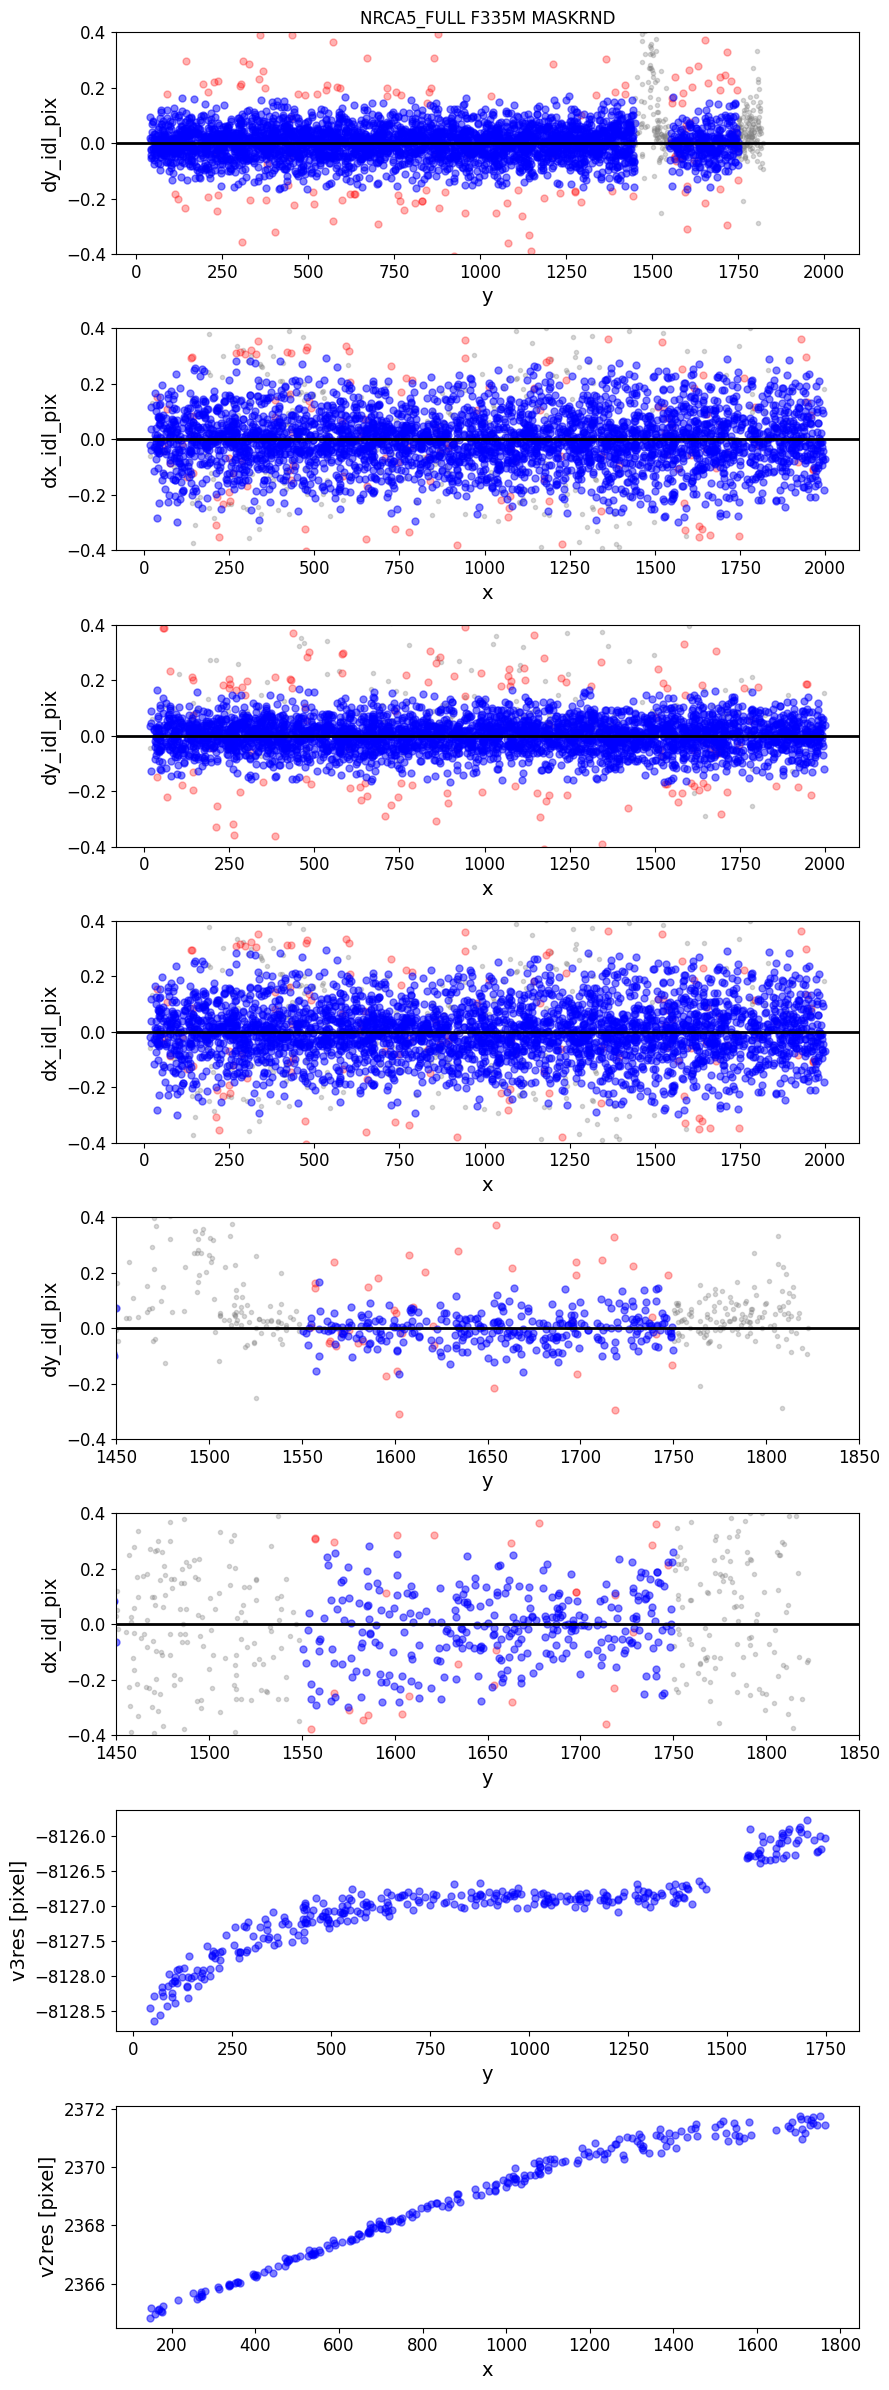

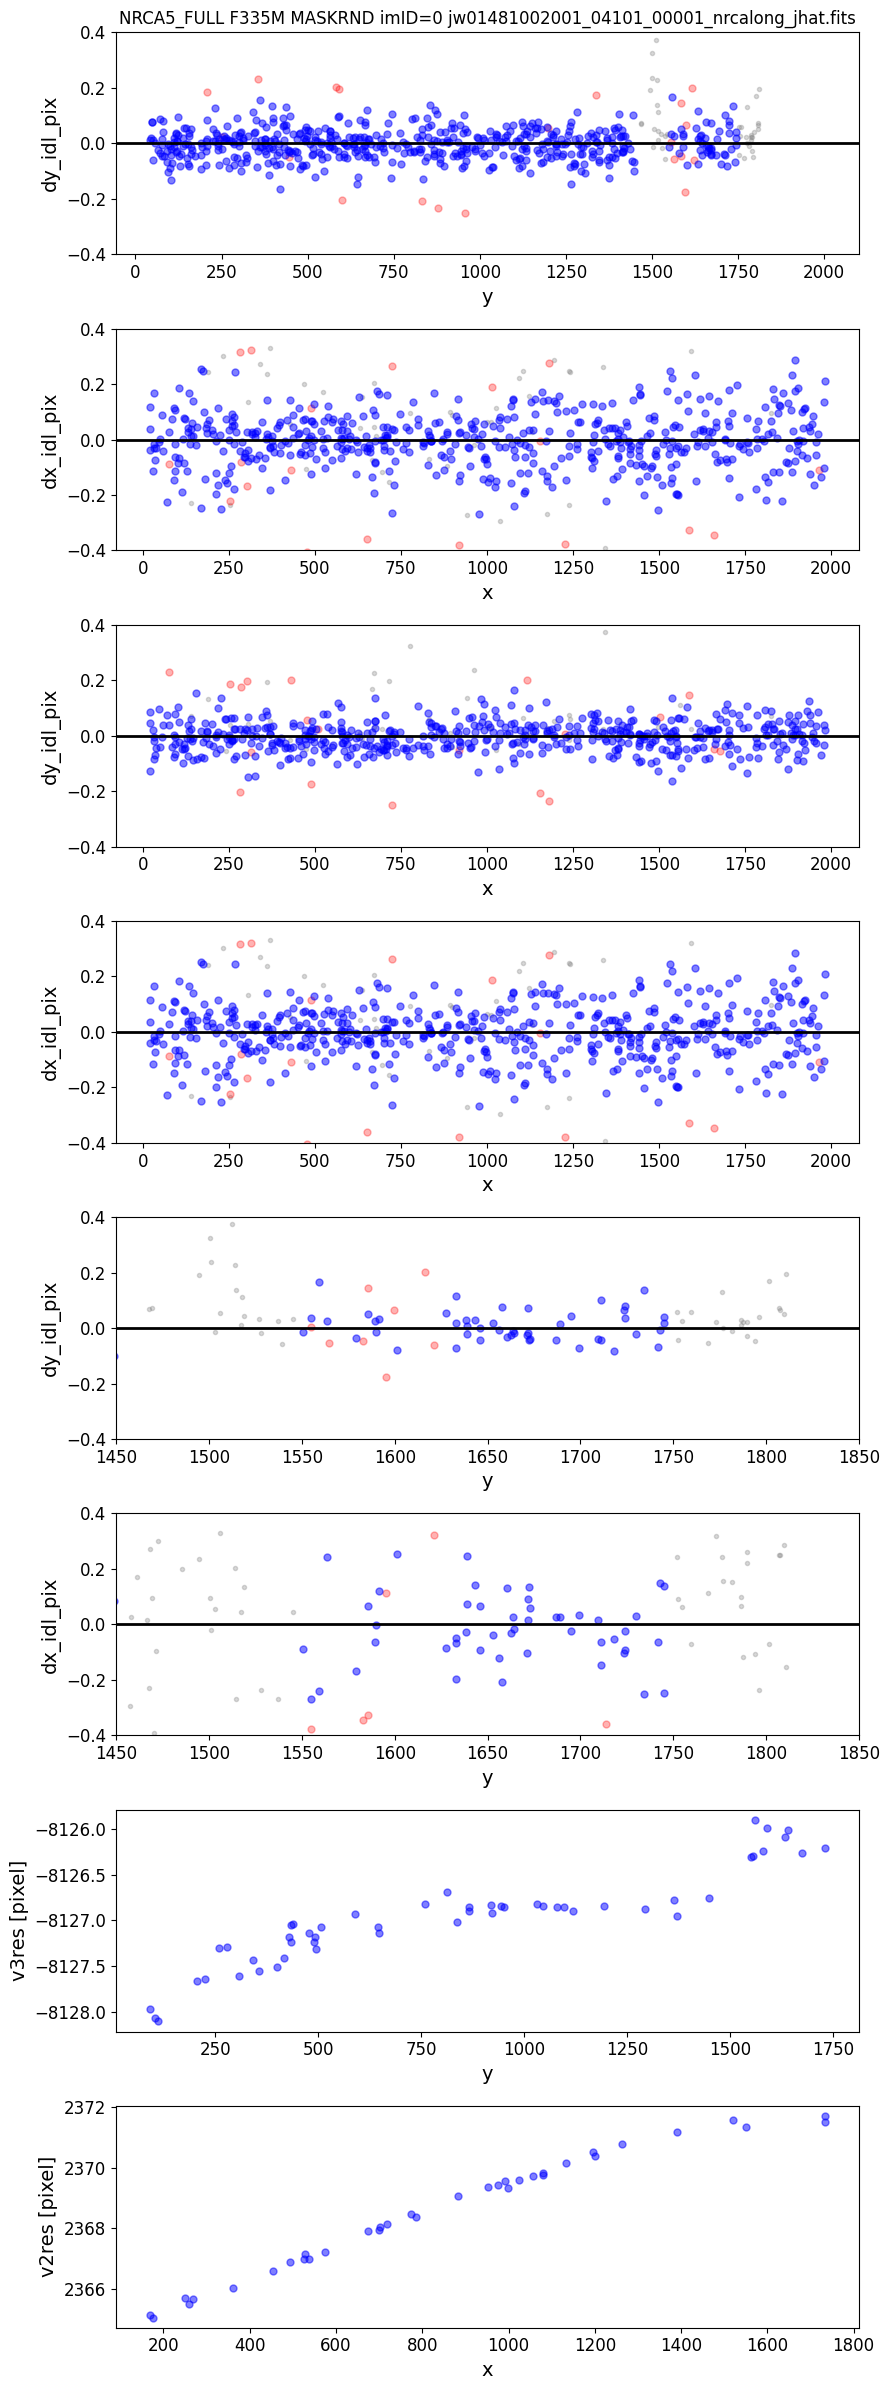

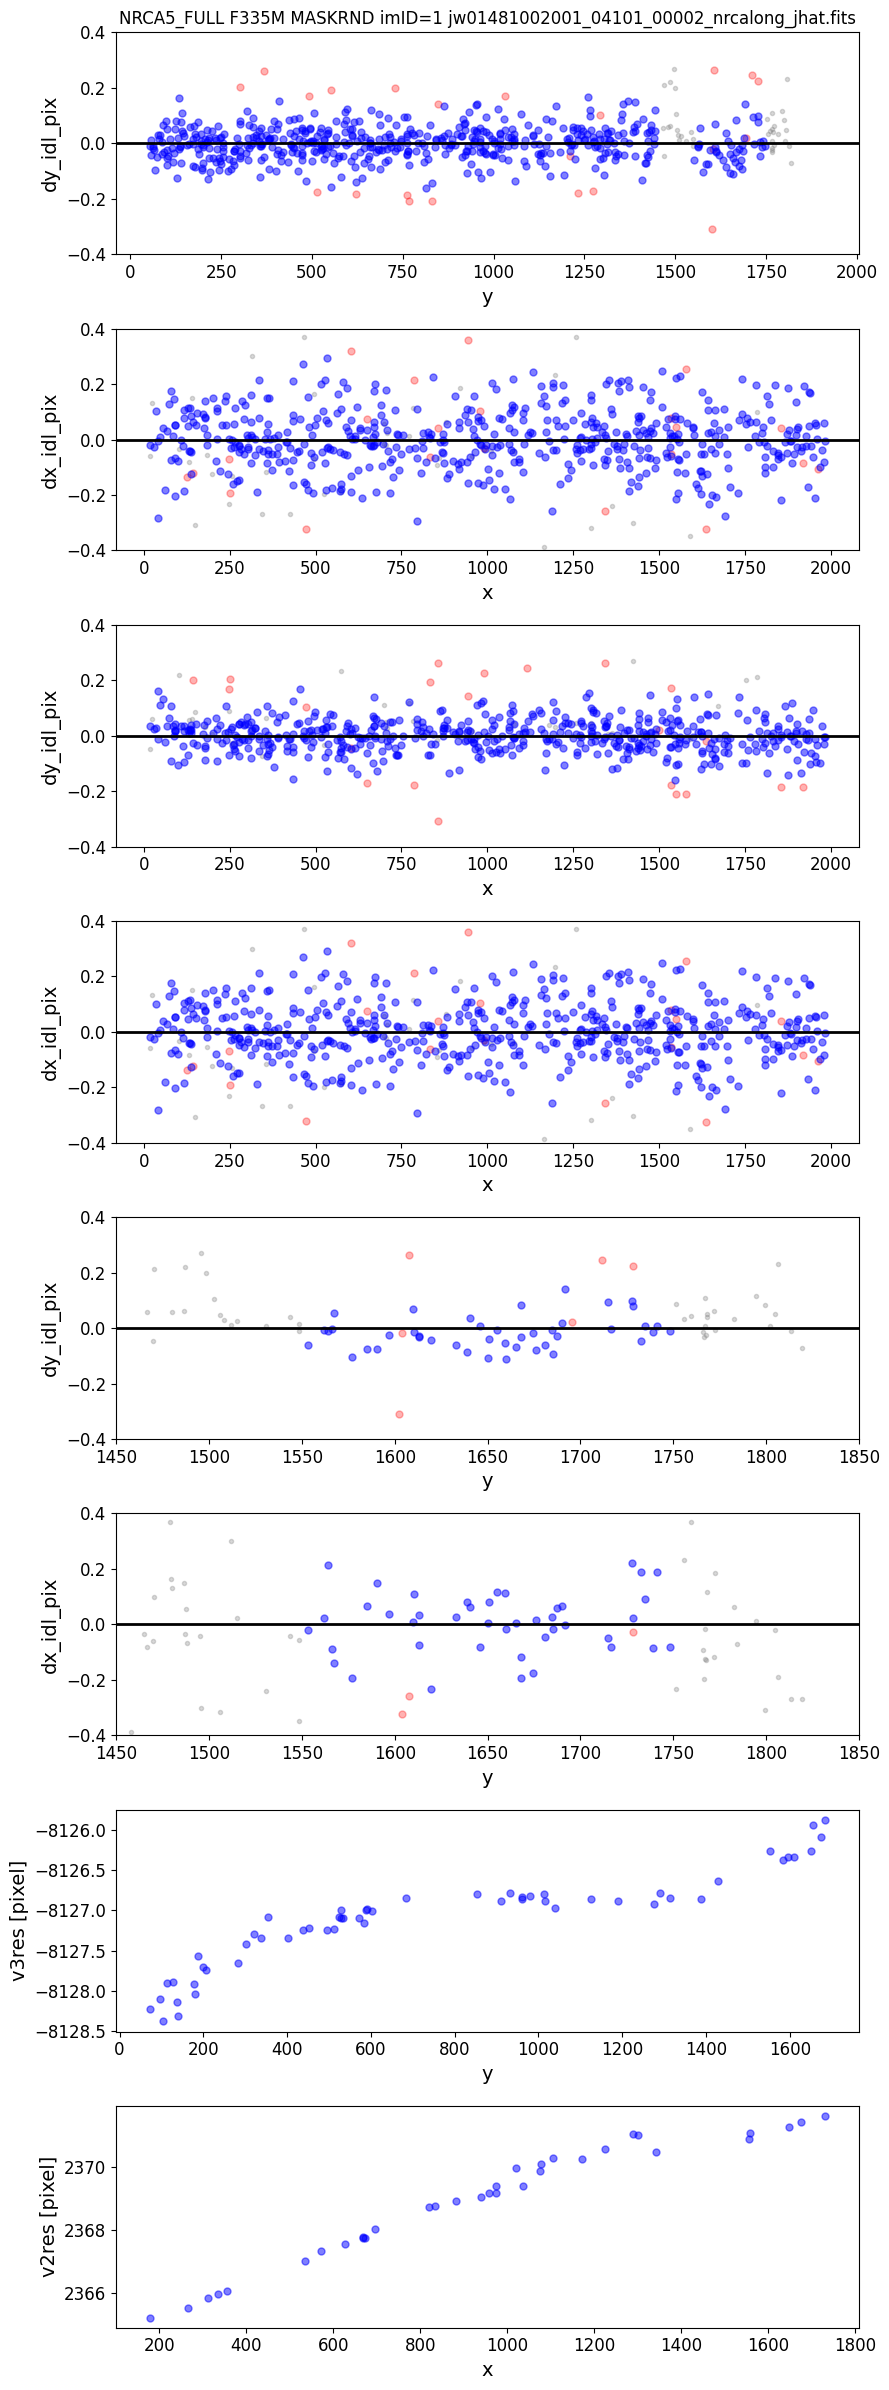

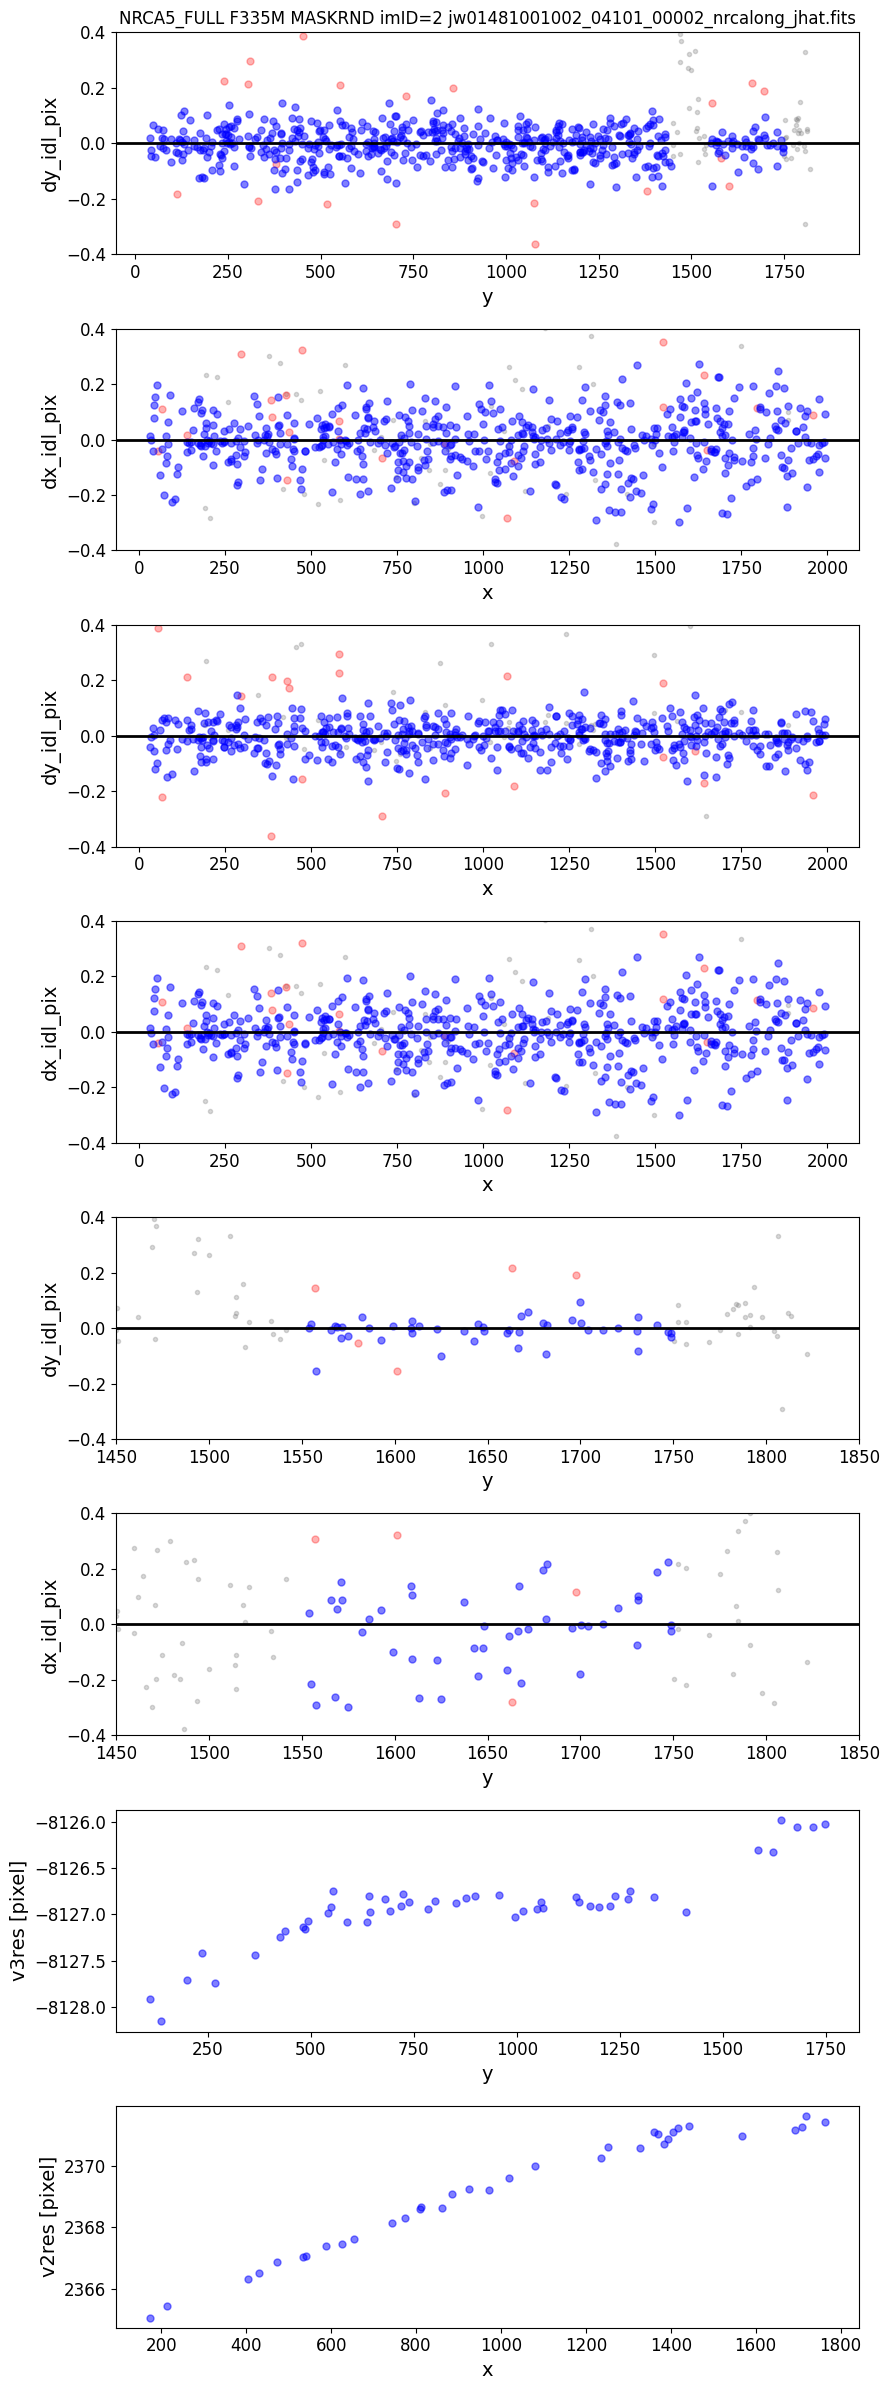

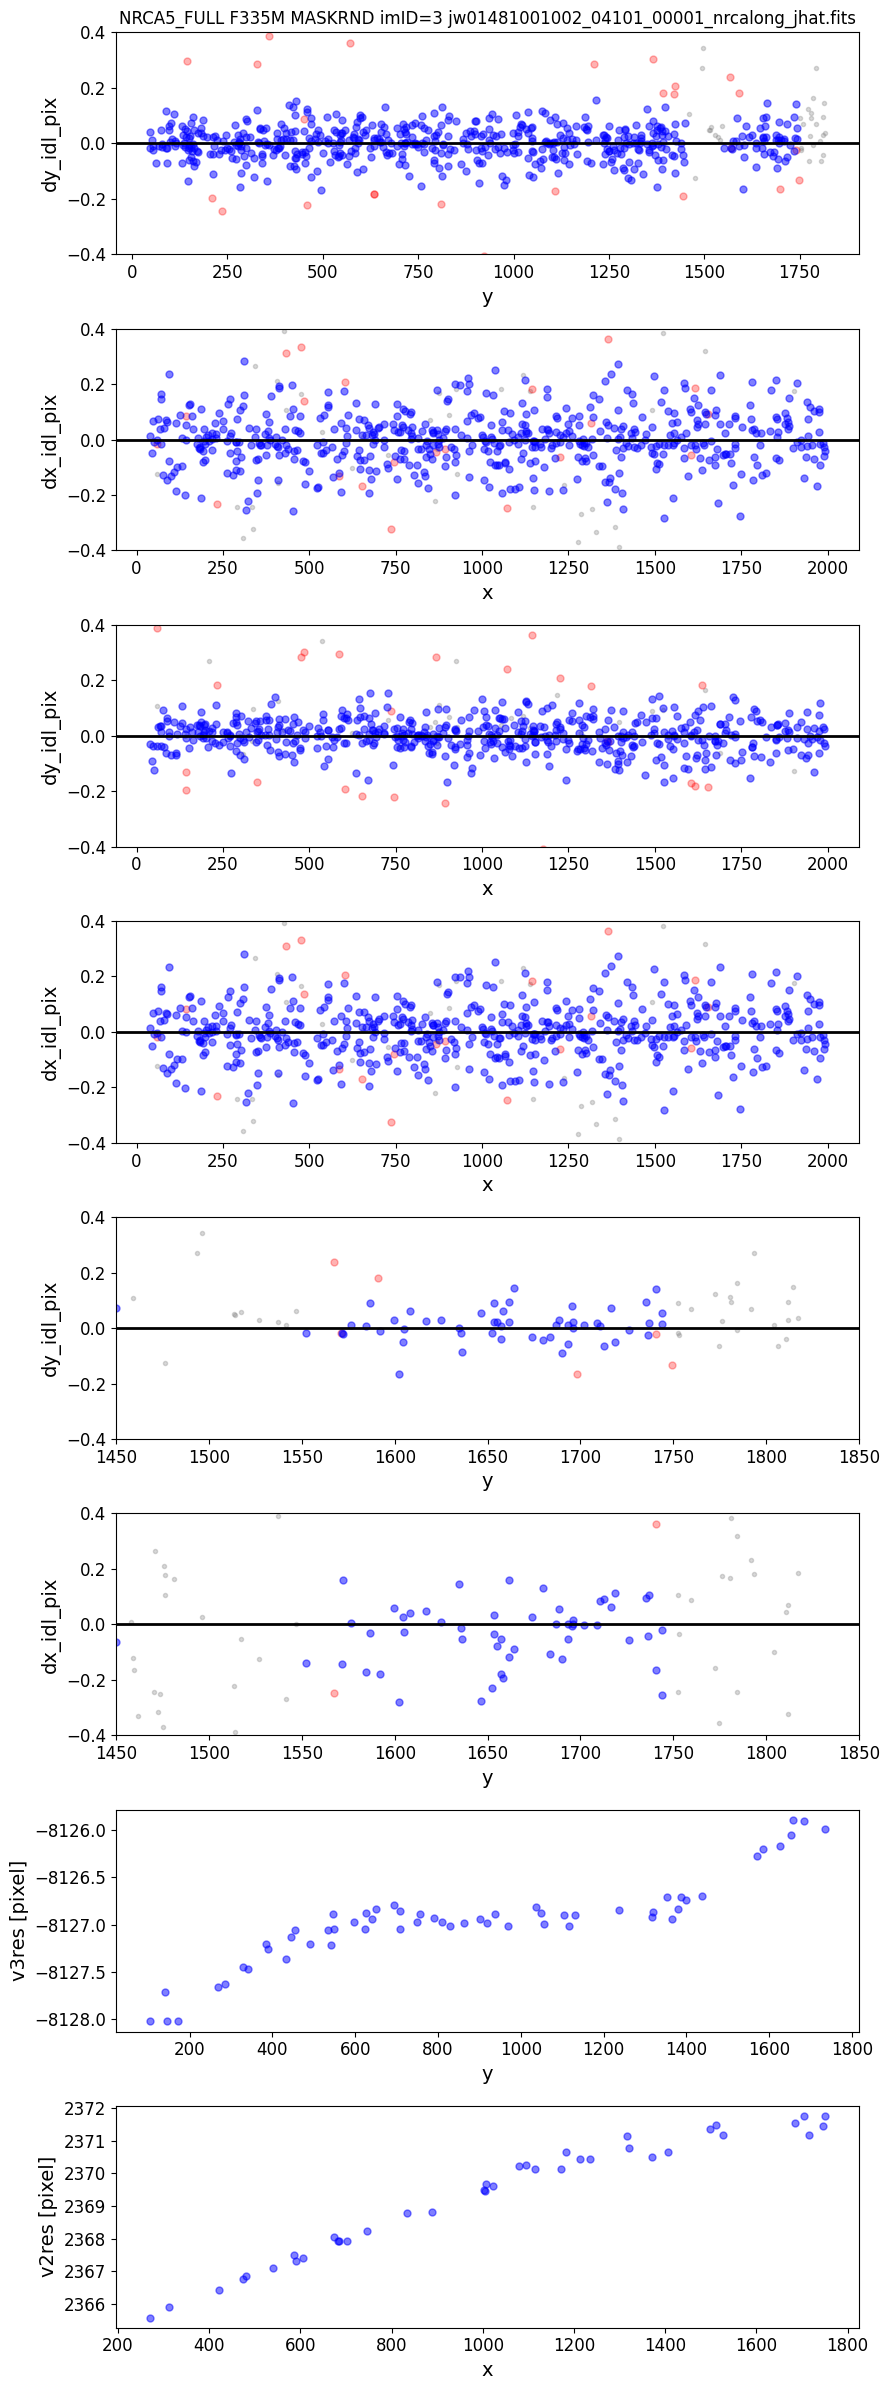

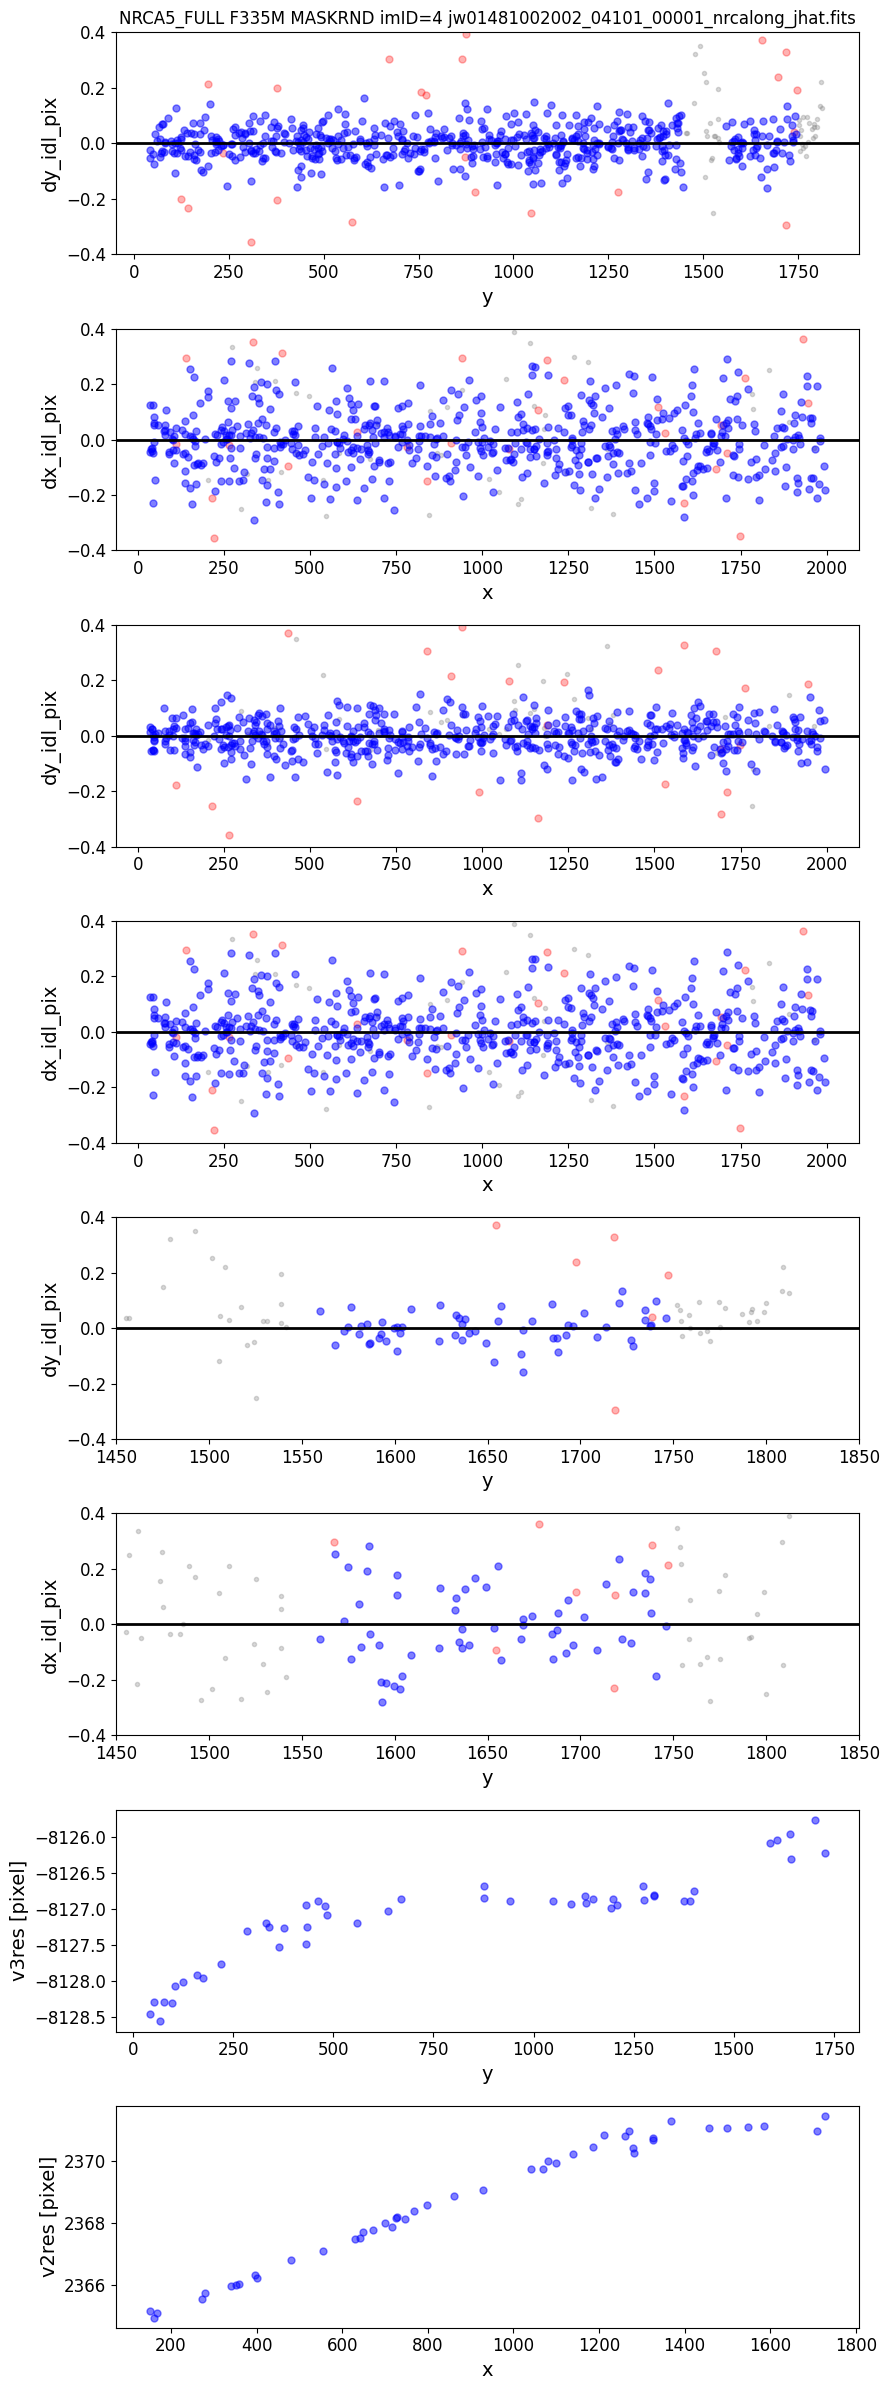

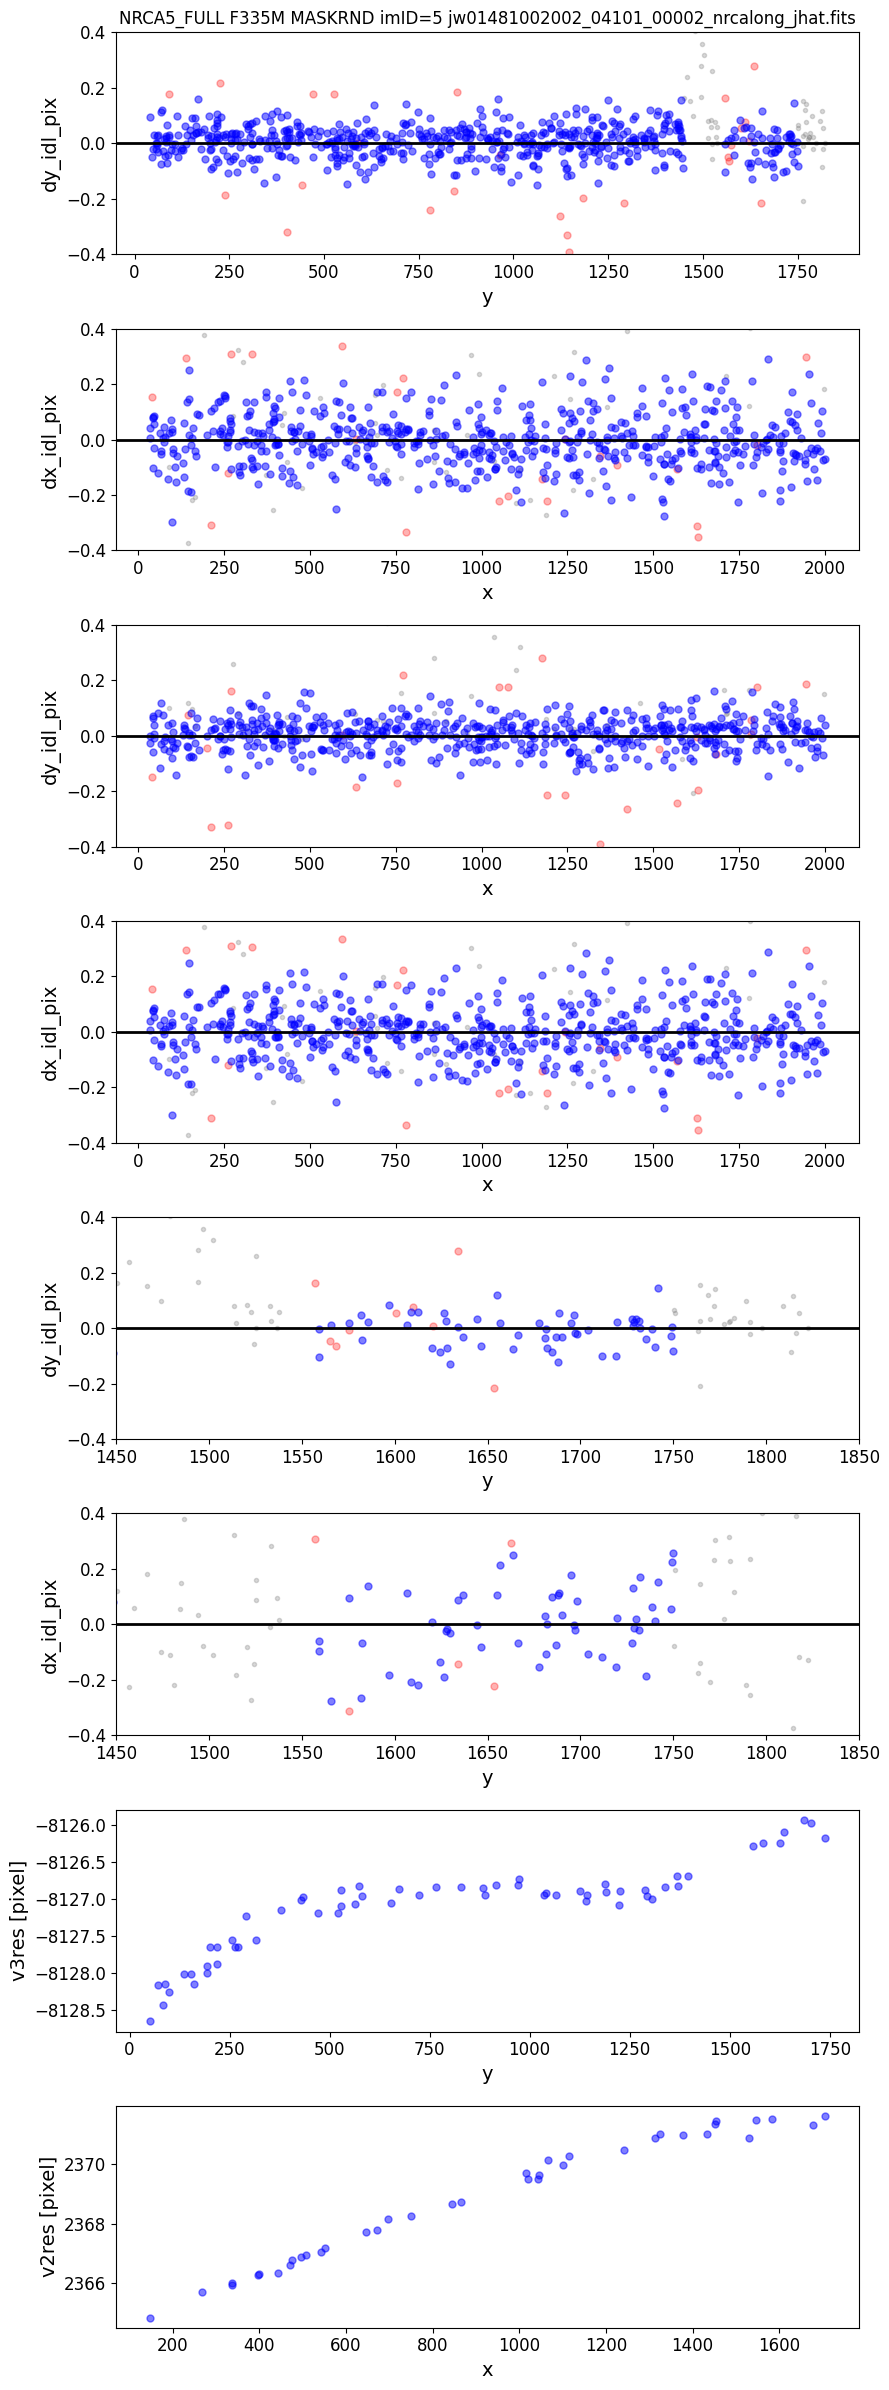

In [44]:
# limits for plots.
residual_limits = (-0.4,0.4)
COM_yrange = (1450,1850)

imIDs = [-1] # -1 is used for all imIDs
imIDs.extend(unique(matches.t['imID']))
imIDs.sort()
print(imIDs)
for imID in imIDs:
    if imID == -1:
        plot_residuals(matches, ixs4fit, ixs_cut_3sigma, ixs_excluded,
                       residual_limits = residual_limits,COM_yrange = COM_yrange,
                       COMflag=COMflag,shortflag=False)
        outfilename = f'{outbasename}.all.residuals.png'
        print(f'Saving {outfilename}')
        plt.savefig(outfilename)
    else:
        ixs_imtable = imtable.ix_equal('imID',imID)
        if len(ixs_imtable)!=1: raise RuntimeError(f'BUG!!!! {ixs_imtable}')
        add2title = f'imID={imID} {imtable.t.loc[ixs_imtable[0],"image"]}'
        
        ixs4fit_imID = matches.ix_equal('imID',imID,indices=ixs4fit)
        ixs_cut_3sigma_imID = matches.ix_equal('imID',imID,indices=ixs_cut_3sigma)
        ixs_excluded_imID = matches.ix_equal('imID',imID,indices=ixs_excluded)
        plot_residuals(matches, ixs4fit_imID, ixs_cut_3sigma_imID, ixs_excluded_imID,
                       residual_limits = residual_limits,COM_yrange = COM_yrange,
                       COMflag=COMflag,shortflag=False,
                       add2title=add2title)
        outfilename = f'{outbasename}.imID_{imID}.residuals.png'
        print(f'Saving {outfilename}')
        plt.savefig(outfilename)
        #sys.exit(0)


Saving IDL to SCI residual plot to /Users/arest/nircam/jwst_alignment_tools/coron/distortions/test_v1/NRCA5_FULL_F335M_MASKRND.Idl2Sci.residuals.png


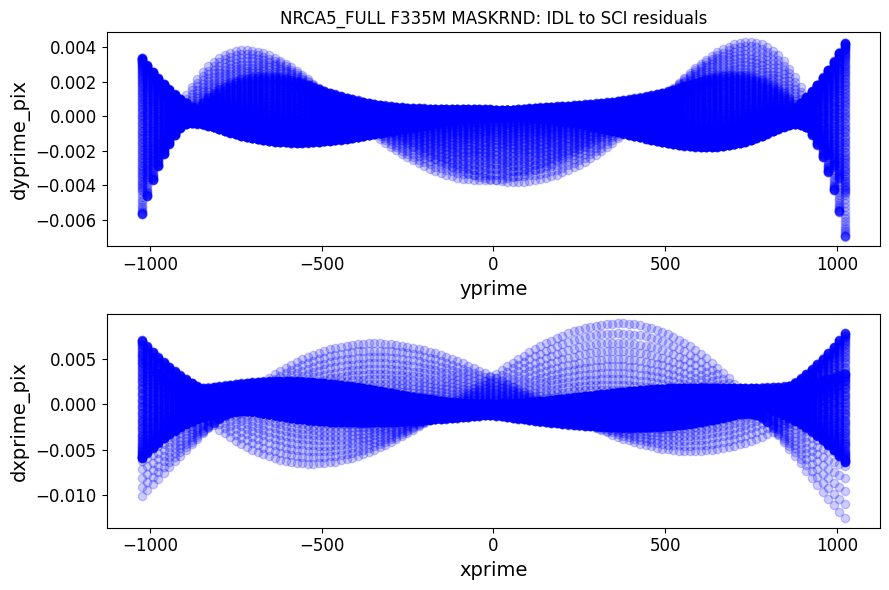

In [53]:
def fit_Idl2Sci(coeff_Sci2IdlX,coeff_Sci2IdlY,poly_degree,siaf_aperture,savepng=None):
    nx, ny = (int(siaf_aperture.XSciSize/16), int(siaf_aperture.XSciSize/16))
    x = np.linspace(1, siaf_aperture.XSciSize, nx)
    y = np.linspace(1, siaf_aperture.YSciSize, ny)
    xgprime, ygprime = np.meshgrid(x-siaf_aperture.XSciRef, y-siaf_aperture.YSciRef)
    
    xg_idl = pysiaf.utils.polynomial.poly(coeff_Sci2IdlX, xgprime, ygprime, order=poly_degree)
    yg_idl = pysiaf.utils.polynomial.poly(coeff_Sci2IdlY, xgprime, ygprime, order=poly_degree)

    coeff_Idl2SciX = polyfit0(xgprime, xg_idl, yg_idl, order=poly_degree)
    coeff_Idl2SciY = polyfit0(ygprime, xg_idl, yg_idl, order=poly_degree)

    # just for debugging!
    xgprime_fit = pysiaf.utils.polynomial.poly(coeff_Idl2SciX, xg_idl, yg_idl, order=poly_degree)
    ygprime_fit = pysiaf.utils.polynomial.poly(coeff_Idl2SciY, xg_idl, yg_idl, order=poly_degree)
    dxgprime_pix  = (xgprime - xgprime_fit)
    dygprime_pix  = (ygprime - ygprime_fit)

    sp = initplot(2,1,xfigsize4subplot=9,yfigsize4subplot=3)
    sp[0].plot(ygprime,dygprime_pix,'bo',alpha=0.2)
    sp[0].set_xlabel('yprime',fontsize=14)
    sp[0].set_ylabel('dyprime_pix',fontsize=14)
    sp[0].set_title(f'{apernamelist[0]} {filtername} {pupilname}: IDL to SCI residuals')

    sp[1].plot(xgprime,dxgprime_pix,'bo',alpha=0.2)
    sp[1].set_xlabel('xprime',fontsize=14)
    sp[1].set_ylabel('dxprime_pix',fontsize=14)
    plt.tight_layout()
    if savepng is not None:
        print(f'Saving IDL to SCI residual plot to {savepng}')
        plt.savefig(savepng)
    return(coeff_Idl2SciX,coeff_Idl2SciY)


(coeff_Idl2SciX,coeff_Idl2SciY) = fit_Idl2Sci(coeff_Sci2IdlX,coeff_Sci2IdlY,
                                              poly_degree,siaf_aperture,
                                              savepng=f'{outbasename}.Idl2Sci.residuals.png')

In [54]:
coeffs = pdastroclass(columns=['AperName','siaf_index','exponent_x','exponent_y','filter','pupil','Sci2IdlX','Sci2IdlY','Idl2SciX','Idl2SciY'])
print(siaf_aperture)
print(range(poly_degree))
for i in range(poly_degree+1):
    exp_x = i
    for j in range(0,i+1):
        siaf_index = i*10+j
        coeffs.newrow({'AperName':apernamelist[0],
                       'siaf_index':siaf_index,
                       'exponent_x':exp_x,
                       'exponent_y':j,
                       'filter':filtername,
                       'pupil':pupilname,
                    })
        exp_x -= 1
coeffs.t['Sci2IdlX']=coeff_Sci2IdlX
coeffs.t['Sci2IdlY']=coeff_Sci2IdlY
coeffs.t['Idl2SciX']=coeff_Idl2SciX
coeffs.t['Idl2SciY']=coeff_Idl2SciY

coeffs.default_formatters['Sci2IdlX']='{:.10e}'.format
coeffs.default_formatters['Sci2IdlY']='{:.10e}'.format
coeffs.default_formatters['Idl2SciX']='{:.10e}'.format
coeffs.default_formatters['Idl2SciY']='{:.10e}'.format

coeffs.write()

JWST NIRCAM aperture named NRCA5_FULL
range(0, 5)
  AperName siaf_index exponent_x exponent_y filter   pupil          Sci2IdlX          Sci2IdlY          Idl2SciX          Idl2SciY
NRCA5_FULL          0          0          0  F335M MASKRND  0.0000000000e+00  0.0000000000e+00  0.0000000000e+00  0.0000000000e+00
NRCA5_FULL         10          1          0  F335M MASKRND  6.2381697860e-02 -6.3287680128e-05  1.6030331601e+01  1.6151814054e-02
NRCA5_FULL         11          0          1  F335M MASKRND  2.5554095607e-06  6.2795673405e-02 -6.5198016291e-04  1.5924650541e+01
NRCA5_FULL         20          2          0  F335M MASKRND  1.3726140067e-07  4.6462301545e-07 -5.6389233033e-04 -1.9036175256e-03
NRCA5_FULL         21          1          1  F335M MASKRND -4.6465402456e-07  2.4366925050e-07  1.9070724187e-03 -9.8796859826e-04
NRCA5_FULL         22          0          2  F335M MASKRND -1.0516097199e-07  2.0207092507e-09  4.2879468354e-04 -5.2378199351e-06
NRCA5_FULL         30          3 

0

In [55]:
outfilename = f'{outbasename}.polycoeff.txt'
print(outfilename)
coeffs.write(outfilename)

/Users/arest/nircam/jwst_alignment_tools/coron/distortions/test_v1/NRCA5_FULL_F335M_MASKRND.polycoeff.txt


0

In [56]:
print('######### dx')
matches.calcaverage_sigmacutloop('dx_idl_pix',indices=ixs4fit,verbose=3,Nsigma=3,percentile_cut_firstiteration=95)
print('\n######### dy')
matches.calcaverage_sigmacutloop('dy_idl_pix',indices=ixs4fit,verbose=3,Nsigma=3,percentile_cut_firstiteration=95)


######### dx


KeyError: 'dx_idl_pix'